# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [4]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, X):
        inputs = X 
        out = self.layers(inputs)
        return out

"Complex" is the NN proposed by Giulio to solve heat and diffusion problem. I added the possibility of having different activation function which can be choosen using the string name. In most of the literature it is suggested to have at least 
two time differentiable function like "sin" and "tanh" for solving the PDE using PINNs.

In [6]:
class Swish(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


class Sin(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)
    
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['swish']:
        return Swish()
    elif name in ['sin']:
        return Sin()
    else:
        raise ValueError('Unknown activation function')
    
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        self.act_string = "sin"
        self.activation = activation(self.act_string) 
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, X):
        x = self.activation(self.ln1(self.fc1(X)))
        x = self.activation(self.ln2(self.fc2(x)))
        x = self.activation(self.ln3(self.fc3(x)))
        x = self.activation(self.ln4(self.fc4(x)))
        x = self.activation(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

In [13]:
def get_mgrid(sidelen, dim=2):
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    if dim == 2:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1]], axis=-1)[None,...].astype(np.float32)
        print(pixel_coords.shape)
        pixel_coords[0, :, :, 0] = pixel_coords[0, :, :, 0] / (sidelen[0] - 1)
        pixel_coords[0, :, :, 1] = pixel_coords[0, :, :, 1] / (sidelen[1] - 1)
    elif dim == 3:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1], :sidelen[2]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[..., 0] = pixel_coords[..., 0] / max(sidelen[0] - 1, 1)
        pixel_coords[..., 1] = pixel_coords[..., 1] / (sidelen[1] - 1)
        pixel_coords[..., 2] = pixel_coords[..., 2] / (sidelen[2] - 1)
    pixel_coords -= 0.5
    pixel_coords *= 2.
    pixel_coords = torch.Tensor(pixel_coords).view(-1, dim)
    return pixel_coords
    

In [64]:
class SineLayer(torch.nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output       

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [11]:
class DiffDataset(Dataset):
    def __init__ (self, sidelength,pretrain=False):
        super().__init__()
        torch.manual_seed(4321)
        self.sidelength = sidelength
        self.pretrain = pretrain
        self.mgrid = get_mgrid(self.sidelength).detach()
        self.Nsamples = 1000 
        self.counter = 0
        self.full_count = 10000
        # boundary values
        self.x_bc = torch.zeros(self.sidelength, 1).uniform_(0,2)
        self.y_bc = torch.zeros(self.sidelength, 1).uniform_(0,2)

    def __len__(self):
        return 1
        
    def analytic_sol_func(self, coords): 
        return torch.exp(coords[:,1] + coords[:,2]) * torch.cos(coords[:,1] + coords[:,2] + 4*coords[:,0])

    def __getitem__(self, index):
        start_time = 0.0
        # uniformly sample domain and include coordinates
        coords = torch.zeros(self.sidelength ** 2, 2).uniform_(0,2)

        # boundary values 
        # t, x, y, here the time is 0 and it is probably wrong!!!
        boundary = torch.cat([torch.zeros_like(self.x_bc), self.x_bc, self.y_bc],1)
        boundary_values = self.analytic_sol_func(boundary).unsqueeze(-1)
        dirichlet1 = torch.cat([torch.ones_like(self.x_bc)*2,self.y_bc],1)
        dirichlet2 = torch.cat([torch.zeros_like(self.x_bc),self.y_bc],1)
        dirichlet3 = torch.cat([self.x_bc, torch.zeros_like(self.y_bc)],1)
        dirichlet4 = torch.cat([self.x_bc, torch.ones_like(self.y_bc)*2],1)
        dirichlet  = torch.cat([dirichlet1,dirichlet2,dirichlet3,dirichlet4])

        if self.pretrain:
            # only sample in time around the inital condition
            time = torch.zeros(self.sidelength ** 2, 1).uniform_(start_time - 0.001, start_time + 0.001)
            time_boundary = torch.zeros(dirichlet.shape[0], 1).uniform_(start_time - 0.001, start_time + 0.001)
            coords = torch.cat((time, coords), dim=1)
            dirichlet = torch.cat((time_boundary, dirichlet),dim=1)
        else:
            # slowly grow time values from start time
            time = torch.zeros(self.sidelength ** 2, 1).uniform_(0,0.4*(self.counter / self.full_count))
            time_boundary = torch.zeros(dirichlet.shape[0], 1).uniform_(0,0.4*(self.counter / self.full_count))
            coords = torch.cat((time,coords), dim=1)
            dirichlet = torch.cat((time_boundary, dirichlet),dim=1)
        self.counter += 1

        if self.pretrain and self.counter == 2000:
            self.pretrain = False
            self.counter = 0
        coords.requires_grad = True
        return {"coords":  coords},{"boundary":boundary, "boundary_values": boundary_values, "dirichlet": dirichlet}        



In [14]:
import matplotlib.pyplot as plt
batchsize = 4096
dataset = DiffDataset(32, pretrain=True)
dataloader = DataLoader(dataset, shuffle=True, batch_size=batchsize, pin_memory=True, num_workers=0)
for step, (model_input, gt) in enumerate(dataloader):
    model_input = {key: value for key, value in model_input.items()}
    gt = {key: value for key, value in gt.items()}
    
    print(f"step: {step}")
    print(model_input["coords"].shape)
    print(gt["dirichlet"])

(1, 32, 32, 2)
step: 0
torch.Size([1, 1024, 3])
tensor([[[ 9.0612e-04,  2.0000e+00,  5.7040e-03],
         [-5.0931e-04,  2.0000e+00,  3.3851e-01],
         [ 8.5535e-04,  2.0000e+00,  1.3641e+00],
         [ 7.0201e-05,  2.0000e+00,  1.3460e+00],
         [-3.2501e-04,  2.0000e+00,  2.4710e-01],
         [ 5.2287e-05,  2.0000e+00,  1.6644e+00],
         [-3.0396e-04,  2.0000e+00,  9.8469e-01],
         [-6.1507e-04,  2.0000e+00,  5.8065e-01],
         [-8.9431e-04,  2.0000e+00,  6.3819e-01],
         [ 9.9292e-04,  2.0000e+00,  4.7159e-02],
         [-6.2388e-04,  2.0000e+00,  1.1795e-01],
         [-4.6488e-04,  2.0000e+00,  1.8810e+00],
         [ 4.4232e-04,  2.0000e+00,  1.5681e+00],
         [-3.4898e-04,  2.0000e+00,  8.0121e-01],
         [ 6.2513e-04,  2.0000e+00,  2.4876e-01],
         [-5.8376e-05,  2.0000e+00,  3.8142e-01],
         [-2.7086e-04,  2.0000e+00,  1.2556e+00],
         [-7.1595e-04,  2.0000e+00,  1.2966e+00],
         [ 6.0343e-05,  2.0000e+00,  3.6586e-01],
  

NameError: name 'data' is not defined

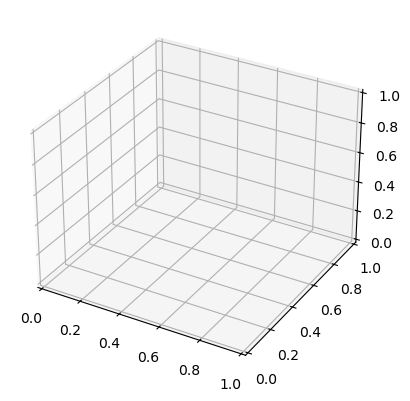

In [67]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')
xm = data[0,2][:,1]
ym = data[0,2][:,2]
X,Y = torch.meshgrid(xm,ym)
um = data.analytic_sol_func(data[0,2])
um = um.reshape(X.shape)

surf = ax.plot_surface(xm, ym, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

Main class of the NN to solve the heat diffusion. Learning rate choosen is "rather" big 0.01 and can be reduced 10x

In [16]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

            # torch.nn.init.xavier_uniform_(m.bias)
            # m.bias.data.fill_(0)

    model.apply(init_weights)


In [17]:
net.analytic_sol_func(torch.tensor([0,1,2]), torch.tensor([1.1,1.2,1.3]), torch.tensor([2.2,2.3,2.3]))

tensor([-26.7732,  11.4790,  20.7984])

In [18]:
net = Net(model="complex")
init_xavier(net.model)  
net.train(10000,dataloader)

c:\Users\ivt\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([141, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 Iter: 0, loss:135.79788208007812
 Iter: 100, loss:107.91766357421875
 Iter: 200, loss:97.53302001953125
 Iter: 300, loss:89.69164276123047
 Iter: 400, loss:83.50975799560547
 Iter: 500, loss:84.6014404296875
 Iter: 600, loss:77.81609344482422
 Iter: 700, loss:73.94261932373047
 Iter: 800, loss:71.22968292236328
 Iter: 900, loss:67.32427978515625
 Iter: 1000, loss:85.98863983154297
 Iter: 1100, loss:146.76751708984375
 Iter: 1200, loss:95.52275085449219
 Iter: 1300, loss:64.29776000976562
 Iter: 1400, loss:47.28334045410156
 Iter: 1500, loss:199.0486297607422
 Iter: 1600, loss:57.11302947998047
 Iter: 1700, loss:44.17278289794922
 Iter: 1800, loss:39.47699737548828
 Iter: 1900, loss:37.95732879638672
 Iter: 2000, loss:1326.408203125
 Iter: 2100, loss:540.966064453125
 Iter: 2200, loss:540.6475219726562
 Iter: 2300, loss:540.3275146484375
 Iter: 2400, loss:540.0052490234375
 Iter: 2500, loss:539.6827392578125
 Iter: 2600, loss:394.06951904296875
 Iter: 2700, loss:459.4947204589844
 Iter

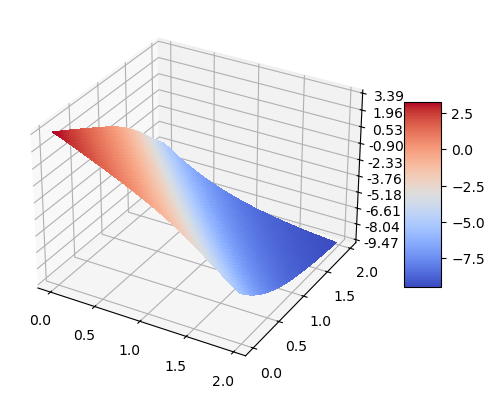

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')

x = np.arange(0,2,0.02)
y = np.arange(0,2,.02)
xm, ym = np.meshgrid(x,y)

x = np.ravel(xm).reshape(-1,1)
y = np.ravel(ym).reshape(-1,1)

x_input = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
y_input = Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
t_input = Variable(torch.ones_like(x_input)*1.2, requires_grad=True).to(device)
X = torch.cat([t_input, x_input,y_input],1)

u_pred = net.model(X)
um = u_pred.data.cpu().numpy()
um = um.reshape(xm.shape)

surf = ax.plot_surface(xm, ym, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [109]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,0)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)

In [110]:
mse

147.53768975481097

## Analytical solution to heat equation

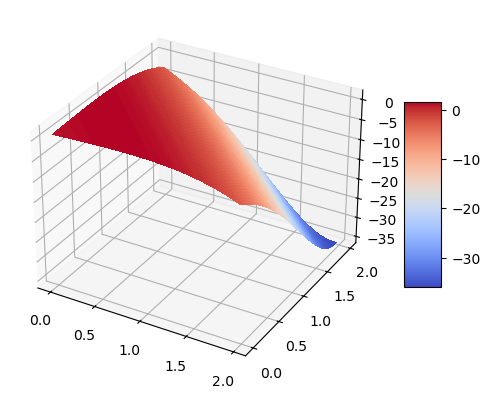

In [111]:
fig2 = plt.figure()
ax2 = plt.axes(projection='3d')

xm = np.arange(0,2,0.02)
ym = np.arange(0,2,.02)
xm, ym = np.meshgrid(xm,ym)
anal_sol = solution(xm,ym,0.0)

surf = ax2.plot_surface(xm, ym, anal_sol, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig2.colorbar(surf, shrink=.5, aspect=5)
plt.show()